In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import unicodedata
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import ast

import warnings
warnings.filterwarnings("ignore")


# Pengambilan Data

In [25]:
# # List of stock tickers (Indonesian example)
# # stocks = ["BBRI.JK", "BMRI.JK", "TLKM.JK"]
# lq45_stocks = [
#     "ACES.JK", "ADMR.JK", "ADRO.JK", "AKRA.JK", "AMMN.JK", "AMRT.JK", "ANTM.JK", "ARTO.JK", 
#     "ASII.JK", "BBCA.JK", "BBNI.JK", "BBRI.JK", "BBTN.JK", "BMRI.JK", "BRIS.JK", "BRPT.JK", 
#     "BUKA.JK", "CPIN.JK", "ESSA.JK", "EXCL.JK", "GOTO.JK", "ICBP.JK", "INCO.JK", "INDF.JK", 
#     "INKP.JK", "INTP.JK", "ISAT.JK", "ITMG.JK", "JSMR.JK", "KLBF.JK", "MAPI.JK", "MBMA.JK", 
#     "MDKA.JK", "MEDC.JK", "MTEL.JK", "PGAS.JK", "PGEO.JK", "PTBA.JK", "SIDO.JK", "SMGR.JK", 
#     "SMRA.JK", "TLKM.JK", "TOWR.JK", "UNTR.JK", "UNVR.JK"
# ]


# def get_stock_data(stock):
#     """Fetch financial metrics, historical returns, and all closing prices with timestamps for a stock."""
#     try:
#         # Initialize ticker object
#         stock_data = yf.Ticker(stock)

#         # Fetch financials (ROA and ROE calculation)
#         income_statement = stock_data.financials
#         balance_sheet = stock_data.balance_sheet

#         # Extract Net Income, Total Assets, and Shareholder's Equity
#         net_income = income_statement.loc["Net Income"].iloc[0] if "Net Income" in income_statement.index else None
#         total_assets = balance_sheet.loc["Total Assets"].iloc[0] if "Total Assets" in balance_sheet.index else None
#         shareholders_equity = balance_sheet.loc['Stockholders Equity'].iloc[0] if 'Stockholders Equity' in balance_sheet.index else None

#         roa = net_income / total_assets if total_assets else None
#         roe = net_income / shareholders_equity if shareholders_equity else None

#         # Fetch market capitalization
#         market_cap = stock_data.info.get("marketCap", None)

#         # Fetch historical data for returns calculation and closing prices
#         hist_data = stock_data.history(period="1y")  # Last 1 year of data
#         hist_data["Daily Return"] = hist_data["Close"].pct_change()

#         mean_return = hist_data["Daily Return"].mean() if not hist_data["Daily Return"].isnull().all() else None
#         variance_return = hist_data["Daily Return"].var() if not hist_data["Daily Return"].isnull().all() else None

#         # Get all closing prices with timestamps
#         closing_prices_with_timestamps = hist_data[["Close"]].reset_index()  # Reset index to include dates
#         # Convert the 'Date' to the desired format 'Y-m-d'
#         closing_prices_with_timestamps["Date"] = closing_prices_with_timestamps["Date"].dt.strftime('%Y-%m-%d')

#         closing_prices_with_timestamps = closing_prices_with_timestamps[["Date", "Close"]].to_dict(orient='records')  # Convert to list of dicts

#         if stock =='MEDC.JK':
#             roa = 0.0510
#             roe = 0.2169
#         return {
#             "Ticker": stock,
#             "ROA": roa,
#             "ROE": roe,  # Updated to include ROA, but you may need to replace with correct ROE
#             "Market Cap": market_cap,
#             "Mean Return": mean_return,
#             "Variance Return": variance_return,
#             "Closing Prices with Timestamps": closing_prices_with_timestamps,
#         }
#     except Exception as e:
#         print(f"Error fetching data for {stock}: {e}")
#         return {
#             "Ticker": stock,
#             "ROA": None,
#             "ROE": None,
#             "Market Cap": None,
#             "Mean Return": None,
#             "Variance Return": None,
#             "Closing Prices with Timestamps": None,
#         }

# # Loop through all tickers and collect data
# results = [get_stock_data(stock) for stock in lq45_stocks]
# df = pd.DataFrame(results)
# df

# # Optionally, save to CSV for future use:
# # # df.to_csv("New_Data Saham dan Finansial LQ45.csv", index = False)


In [26]:
data = pd.read_csv("New_Data Saham dan Finansial LQ45.csv")
data.drop(['Closing Prices with Timestamps'], axis=1, inplace=True)
data.drop(['ROA'], axis=1, inplace=True)
data.set_index('Ticker', drop = True, inplace = True)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(data), columns = scaler.get_feature_names_out(), index = data.index)


# CLustering GMM

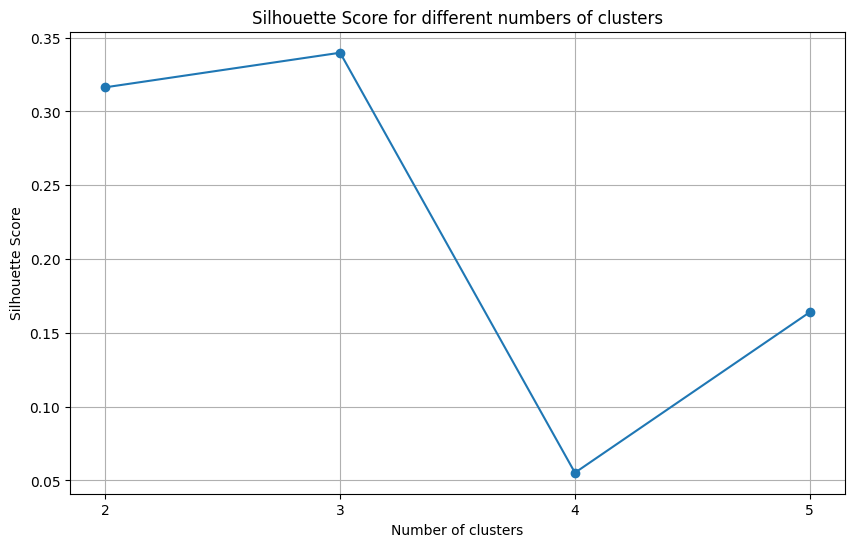

In [27]:
from sklearn.mixture import GaussianMixture

silhouette_scores = []
cluster_range = range(2, 6)  # Ubah range ini sesuai kebutuhan Anda

for n_clusters in cluster_range:
    gmm_cluster = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm_cluster.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 4. Plot Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [28]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

gmm_cluster = GaussianMixture(n_components=3, random_state=42)
cluster_labels = gmm_cluster.fit_predict(df_scaled)

# 4. Calculate Evaluation Metrics
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
davies_bouldin_avg = davies_bouldin_score(df_scaled, cluster_labels)
calinski_harabasz_avg = calinski_harabasz_score(df_scaled, cluster_labels)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_avg}')

# 5. Add cluster labels to the original DataFrame (optional)
data['Cluster'] = cluster_labels

Silhouette Score: 0.339741582822534
Davies-Bouldin Index: 1.1273667687682063
Calinski-Harabasz Index: 10.159000831136922


In [29]:
# Risk-free rate (contoh: 3% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROE        Market Cap  Mean Return  Variance Return  Cluster  \
Ticker                                                                       
ADMR.JK  0.451713    53555809484800     0.000354         0.000646        0   
PGAS.JK  0.103040    38422777430016     0.002017         0.000332        1   
BBCA.JK  0.200693  1241995691425792     0.000782         0.000194        2   

         sharpe_ratio  
Ticker                 
ADMR.JK      0.004564  
PGAS.JK      0.097624  
BBCA.JK      0.039002  


In [30]:
data = pd.read_csv("New_Data Saham dan Finansial LQ45.csv")
data.drop(['ROA'], axis=1, inplace=True)

In [31]:
data = data[['Ticker', 'Closing Prices with Timestamps']]
data = data[data['Ticker'].isin(['ADMR.JK', 'PGAS.JK', 'BBCA.JK'])]
data

# Ekspansi data berdasarkan 'Closing Prices with Timestamps'
expanded_data = data.explode('Closing Prices with Timestamps')

# Konversi isi kolom JSON menjadi DataFrame
expanded_data['Closing Prices with Timestamps'] = expanded_data['Closing Prices with Timestamps'].apply(eval)
expanded_df = expanded_data.explode('Closing Prices with Timestamps')

# Membuat DataFrame baru dengan kolom terpisah
processed_df = pd.DataFrame(list(expanded_df['Closing Prices with Timestamps']))
processed_df['Ticker'] = expanded_df['Ticker'].values

# Pivot DataFrame
result_df = processed_df.pivot(index='Date', columns='Ticker', values='Close')

# Tampilkan hasil
result_df

Ticker,ADMR.JK,BBCA.JK,PGAS.JK
Date,,,
2023-12-06,1300.0,8559.092773,1020.066467
2023-12-07,1305.0,8583.408203,1001.931946
2023-12-08,1370.0,8510.461914,1001.931946
2023-12-11,1390.0,8510.461914,1001.931946
2023-12-12,1395.0,8461.830078,988.331055
...,...,...,...
2024-12-02,1250.0,9750.000000,1570.000000
2024-12-03,1250.0,10200.000000,1585.000000
2024-12-04,1275.0,10200.000000,1595.000000


# Normalitas

In [32]:
# Menghitung log return
from scipy.stats import kstest
log_return = np.log(result_df / result_df.shift(1)).dropna()

# Hasil log return
print("Log Return:")
print(log_return)

# Uji KS-Test untuk log return setiap saham
for ticker in log_return.columns:
    stat, p_value = kstest(log_return[ticker].dropna(), 'norm', args=(log_return[ticker].mean(), log_return[ticker].std()))
    print(f"\nHasil uji KS-Test untuk {ticker}:")
    print(f"KS Statistic: {stat}")
    print(f"P-value: {p_value}")

    # Interpretasi hasil
    if p_value < 0.05:
        print(f"Hasil: Distribusi log return {ticker} berbeda secara signifikan dari distribusi normal.")
    else:
        print(f"Hasil: Distribusi log return {ticker} tidak berbeda signifikan dari distribusi normal.")

Log Return:
Ticker       ADMR.JK   BBCA.JK   PGAS.JK
Date                                    
2023-12-07  0.003839  0.002837 -0.017938
2023-12-08  0.048608 -0.008535  0.000000
2023-12-11  0.014493  0.000000  0.000000
2023-12-12  0.003591 -0.005731 -0.013668
2023-12-13 -0.066691 -0.002878 -0.009217
...              ...       ...       ...
2024-12-02  0.020203 -0.025318  0.032365
2024-12-03  0.000000  0.045120  0.009509
2024-12-04  0.019803  0.000000  0.006289
2024-12-05  0.034686  0.004890 -0.015798
2024-12-06 -0.007605 -0.017221  0.009509

[238 rows x 3 columns]

Hasil uji KS-Test untuk ADMR.JK:
KS Statistic: 0.07170138814571597
P-value: 0.16481653510478556
Hasil: Distribusi log return ADMR.JK tidak berbeda signifikan dari distribusi normal.

Hasil uji KS-Test untuk BBCA.JK:
KS Statistic: 0.06841053534570063
P-value: 0.2056689530369865
Hasil: Distribusi log return BBCA.JK tidak berbeda signifikan dari distribusi normal.

Hasil uji KS-Test untuk PGAS.JK:
KS Statistic: 0.0815744263848400

# SA

In [33]:
returns_df = log_return.copy()

In [34]:
np.random.seed(42)
# Calculate covariance of historical returns
cov_hist_return=returns_df.cov()
# For ease of calculations make covariance of same variable as zero.
for i in range(3):
    cov_hist_return.iloc[i][i]=0
# Calculate the mean of historical returns
mean_hist_return=returns_df.mean()
# Calculate Standard deviation of historical returns:
sd_hist_return=returns_df.std()

In [35]:
def mean_portfolio_return(weights):
    return np.sum(np.multiply(weights,mean_hist_return))

def var_portfolio_return(weights):
    part_1 = np.sum(np.multiply(weights,sd_hist_return)**2)
    temp_lst=[]
    for i in range(3):
        for j in range(3):
            temp=cov_hist_return.iloc[i][j] * weights[i] * weights[j]
            temp_lst.append(temp)
    part_2=np.sum(temp_lst)
    return part_1+part_2

rf = 0.06 / 252

def fitness_function(weights, rf = rf, lower = 1e-3):
    """Calculate portfolio fitness for given weights"""
    return (mean_portfolio_return(weights)-rf)/np.sqrt(np.max([var_portfolio_return(weights), lower]))
# Generates random answer in bound[a,b] with sum 1
def random_weights(n, a = -1, b = 1):
    k = np.random.uniform(a, b, (n))
    while(np.sum(k) < 1):
        k = np.random.uniform(a, b, (n))
    return k / np.sum(k)
def sa(dim = 3, bound = [-1, 1], n_iter=10000, initial_temp=1000, cool_rate=0.95, rf = rf, lower = 1e-3, showlog = False):
    """Solve portfolio optimization problem using simulated annealing"""
    
    # initialize variables
    m = n_iter
    current_weights = random_weights(dim, bound[0], bound[1])  # initial weights
    best_weights = current_weights.copy()  # best observed weights
    current_fitness = fitness_function(current_weights, rf , lower)  # initial return
    best_fitness = current_fitness  # best observed return

    # iterate for m iterations
    for i in range(m):
        # decrease temperature
        temp = initial_temp * (cool_rate ** i)

        # generate new candidate
        candidate_weights = random_weights(dim, bound[0], bound[1])
        candidate_fitness = fitness_function(candidate_weights, rf , lower)

        # calculate acceptance probability
        delta = candidate_fitness - current_fitness
        if delta >= 0:
            accept_prob = 1.0
        else:
            accept_prob = np.exp(delta / temp)

        # update weights and return
        if np.random.rand() < accept_prob:
            current_weights = candidate_weights
            current_fitness = candidate_fitness

        # update best weights and return
        if current_fitness > best_fitness:
            best_weights = current_weights.copy()
            best_fitness = current_fitness
        if showlog:
            print('Iteration:',i)
            print('Expected returns of {} with risk of {}\n'.format(mean_portfolio_return(best_weights), var_portfolio_return(best_weights)))
        

    # return best weights and return
    return best_weights, best_fitness, var_portfolio_return(best_weights), mean_portfolio_return(best_weights)

In [36]:
sol, fit, risk, ret = sa(dim = 3, n_iter = 1000, bound = [0,1], initial_temp=1000, cool_rate=0.95, rf = 0.06 / 252, lower = 1e-3, showlog = True)

Iteration: 0
Expected returns of 0.0011200103700460763 with risk of 0.00012131856793905034

Iteration: 1
Expected returns of 0.0012104977859951876 with risk of 0.0001297394284705282

Iteration: 2
Expected returns of 0.0012104977859951876 with risk of 0.0001297394284705282

Iteration: 3
Expected returns of 0.0012104977859951876 with risk of 0.0001297394284705282

Iteration: 4
Expected returns of 0.0012104977859951876 with risk of 0.0001297394284705282

Iteration: 5
Expected returns of 0.001232754024248492 with risk of 0.00013038156157131945

Iteration: 6
Expected returns of 0.0012367528720264203 with risk of 0.00019713008607828966

Iteration: 7
Expected returns of 0.0012367528720264203 with risk of 0.00019713008607828966

Iteration: 8
Expected returns of 0.0012367528720264203 with risk of 0.00019713008607828966

Iteration: 9
Expected returns of 0.0012367528720264203 with risk of 0.00019713008607828966

Iteration: 10
Expected returns of 0.0012367528720264203 with risk of 0.00019713008607

In [37]:
print('Portfolio of stocks:')
for i in list(range(3)):
    print(returns_df.columns[i],':',sol[i]) 
print('\nExpected returns of ', ret, "with risk of ", risk, "and fitness ", fit)

Portfolio of stocks:
ADMR.JK : 0.022962423824451187
BBCA.JK : 0.12024472366281513
PGAS.JK : 0.8567928525127336

Expected returns of  0.0016696901715296643 with risk of  0.0002469173989681751 and fitness  0.04527100676409924


# GA

In [38]:
def chromosome(n, a = 0, b = 1):
    ch = np.random.uniform(a, b, n)
    while (np.sum(ch)<1):
        ch = np.random.uniform(a, b, n)
    return ch/np.sum(ch)
child=chromosome(3) #range
print("child = ", child)
print("Sum = ", np.sum(child))

child =  [0.39212796 0.45674811 0.15112393]
Sum =  1.0


In [39]:
n=3 # range
pop_size=100 # initial population = 100
np.random.seed(42)
population = np.array([chromosome(n) for _ in range(pop_size)])
print("Population: ", len(population),"\n")
for pop in population:
    print(pop)

Population:  100 

[0.18205878 0.46212909 0.35581214]
[0.03807826 0.56784481 0.39407693]
[0.41686469 0.01211874 0.57101657]
[0.67865488 0.173111   0.14823412]
[0.18115758 0.3005149  0.51832752]
[0.32354776 0.21814475 0.45830749]
[0.31651311 0.54491305 0.13857384]
[0.44595846 0.51375845 0.04028309]
[0.34848152 0.35463173 0.29688675]
[0.28035754 0.08989454 0.62974792]
[0.41627195 0.11541703 0.46831101]
[0.02859779 0.75619858 0.21520363]
[0.4433659  0.20859987 0.34803422]
[0.321377   0.10866445 0.56995855]
[0.29704731 0.36003589 0.34291679]
[0.37176668 0.5732098  0.05502352]
[0.26107384 0.18226466 0.5566615 ]
[0.30223499 0.23800266 0.45976235]
[0.13847708 0.78826685 0.07325607]
[0.50406735 0.39443563 0.10149702]
[0.00361433 0.53373452 0.46265115]
[0.46306098 0.4899063  0.04703272]
[0.26802414 0.08663507 0.64534078]
[0.61242483 0.32512558 0.06244959]
[0.22769713 0.23809491 0.53420796]
[0.31926    0.44427609 0.23646392]
[0.07504546 0.4475615  0.47739304]
[0.30737399 0.42220718 0.27041883]
[

### **Fitness Function (Sharpe Ratio)**
The Sharpe ratio, S, is a measure for quantifying the perfomnace of the portfolio which works on ""Maximisation of return (mean) and minimisation of risk (Variance) simultaneosly" and is computed as follows:

            S = (µ - r)/σ
Here µ is the return of the portfolio over a specified period or Mean portfolio return

        µ = Mean Return * Fractions of Total Capital (Chromosome). 
r is the risk-free rate over the same period

        r = 0.0697 (based on Google)
σ is the standard deviation of the returns over the spwcified period or Standard deviation of the portfolio return.

        σ = (chromosome * Standard deviation)**2 + Covariance * Respective weights in chromosome.

In [40]:
cols=returns_df.columns
returns_df[cols] = returns_df[cols].apply(pd.to_numeric, errors='coerce')


In [41]:
mean_hist_return=returns_df.mean()
sd_hist_return=returns_df.std()
cov_hist_return=returns_df.cov()
for i in range(3):
    cov_hist_return.iloc[i][i]=0   

In [42]:
def mean_portfolio_return(child):
    return np.sum(np.multiply(child,mean_hist_return))
def var_portfolio_return(child):
    part_1 = np.sum(np.multiply(child,sd_hist_return)**2)
    temp_lst=[]
    for i in range(3):
        for j in range(3):
            temp=cov_hist_return.iloc[i][j] * child[i] * child[j]
            temp_lst.append(temp)
    part_2=np.sum(temp_lst)
    return part_1+part_2
rf = 0.06/252
def fitness_function(child, rf = rf, lower = 1e-3):
    return (mean_portfolio_return(child)-rf)/np.sqrt(np.max([var_portfolio_return(child), lower]))

### **Select Elite Population**
Filters the elite choromoome which have highest returns, witch was calculated in fitness function.

In [43]:
def Select_elite_population(population, frac=0.3, rf = rf, lower = 1e-3):
    population = sorted(population,key = lambda x: fitness_function(x, rf, lower),reverse=True)
    percentage_elite_idx = int(np.floor(len(population)* frac))
    return population[:percentage_elite_idx]

In [44]:
Elite_Population = Select_elite_population(population, frac=0.3)
print(len(Elite_Population))
for i in range(len(Elite_Population)):
    print(Elite_Population[i])

30
[0.07352817 0.14124398 0.78522785]
[0.08559426 0.24108649 0.67331925]
[0.19628146 0.07555995 0.72815858]
[0.28171791 0.01176362 0.70651848]
[0.24728688 0.08227289 0.67044023]
[0.03442137 0.44589613 0.5196825 ]
[0.03114431 0.45132776 0.51752793]
[0.26802414 0.08663507 0.64534078]
[0.08952353 0.36795902 0.54251744]
[0.28035754 0.08989454 0.62974792]
[0.00361433 0.53373452 0.46265115]
[0.04599362 0.47287365 0.48113273]
[0.01389859 0.52777377 0.45832764]
[0.07504546 0.4475615  0.47739304]
[0.17615008 0.28997689 0.53387302]
[0.18165688 0.29388772 0.5244554 ]
[0.18115758 0.3005149  0.51832752]
[0.26107384 0.18226466 0.5566615 ]
[0.22769713 0.23809491 0.53420796]
[0.09204267 0.46251368 0.44544365]
[0.321377   0.10866445 0.56995855]
[0.08489623 0.48956209 0.42554168]
[0.03807826 0.56784481 0.39407693]
[0.17705923 0.36808026 0.45486052]
[0.35843368 0.08969069 0.55187563]
[0.20919114 0.33578409 0.45502477]
[0.41686469 0.01211874 0.57101657]
[0.15824714 0.42290762 0.41884524]
[0.31588764 0.197

### **Mutation**
A function that will perform mutation in a chromosome.Randomly we shall Choose 2 numbers between 0, 2 and those elements we shall swap. (*menukar 2 dari 3 bobot*)

In [45]:
def mutation(parent):
    child=parent.copy()
    n=np.random.choice(range(3),2)
    while (n[0]==n[1]):
        n=np.random.choice(range(3),2)
    child[n[0]],child[n[1]]=child[n[1]],child[n[0]]
    return child

### **Crossover** 
Using Blend CrossOver that uses fitness values of two parents choromosome to ascertain the direction of the search. it moves from worst parent to best parent.

The offspring are created acoording to the equation:

        OffSpring_A = Best Parent  + β ∗ ( Best Parent − Worst Parent)
        Offspring_B = Worst Parent - β ∗ ( Best Parent − Worst Parent)
Where β is a random number between 0 and 1.

In [46]:
def Blend_crossover(parent1,parent2):
    beta=np.random.rand()
    ff1=fitness_function(parent1)
    ff2=fitness_function(parent2)
    diff=parent1 - parent2
    if ff1>ff2:
        child1=parent1 + beta * diff
        child2=parent2 - beta * diff
    else:
        child2=parent1 + beta * diff
        child1=parent2 - beta * diff
    return child1,child2
for i in population[:30]:
    for j in population[:30]:
        BC = Blend_crossover(i,j)
        print("Child1 = ", BC[0])
        print("Child2 = ", BC[1])
        print("\n")

Child1 =  [0.18205878 0.46212909 0.35581214]
Child2 =  [0.18205878 0.46212909 0.35581214]


Child1 =  [-0.09747433  0.66737244  0.43010189]
Child2 =  [0.31761137 0.36260145 0.31978718]


Child1 =  [ 0.50752388 -0.16163144  0.65410756]
Child2 =  [0.09139959 0.63587927 0.27272114]


Child1 =  [-0.29526472  0.73993055  0.55533417]
Child2 =  [ 1.15597838 -0.10469046 -0.05128791]


Child1 =  [0.18034168 0.1541974  0.66546092]
Child2 =  [0.18287467 0.60844659 0.20867873]


Child1 =  [0.35125005 0.17037478 0.47837517]
Child2 =  [0.15435649 0.50989906 0.33574446]


Child1 =  [0.17273285 0.45638708 0.37088007]
Child2 =  [0.32583904 0.55065505 0.12350591]


Child1 =  [0.15546349 0.45692598 0.38761053]
Child2 =  [0.47255374 0.51896155 0.00848471]


Child1 =  [0.17902625 0.46408788 0.35688587]
Child2 =  [0.35151405 0.35267293 0.29581302]


Child1 =  [0.28964117 0.0547396  0.65561923]
Child2 =  [0.17277515 0.49728402 0.32994083]


Child1 =  [0.02208959 0.69893577 0.27897465]
Child2 =  [ 0.57624114 

Arithmatic Crossover

The oﬀspring are created according to the equation

        Offf spring A = α ∗ Parent1 + (1 −α) ∗ Parent2
        Off spring B = (1 −α) ∗ Parent1 + α ∗ Parent2
        
Where α is a random number between 0 and 1.

In [47]:
def Arithmetic_crossover(parent1,parent2):
    alpha = np.random.rand()
    child1 = alpha * parent1 + (1-alpha) * parent2
    child2 = (1-alpha) * parent1 + alpha * parent2
    return child1,child2

### **Next Generation**
A function which does mutation,mating or crossover based on a probability and builds a new generation of chromosomes.

next_generation:
Generates new population from elite population with mutation probability as 0.4 and crossover as 0.6. Over the final stages, mutation probability is decreased to 0.1.

In [48]:
# Function used to normalize particles so that they stay in the bounds specified and maintain sum = 1
def normalize(particle, a, b):
    particle += np.min(particle) + np.random.rand()
    particle /= np.max(particle)/(b-a)
    particle += a
    while(np.sum(particle) < 1):
        particle += np.min(particle) + np.random.rand()
        particle /= np.max(particle)/(b-a)
        particle += a
    return particle/np.sum(particle)

In [49]:
def next_generation(pop_size,elite,crossover=Blend_crossover, bound = [0, 1]):
    new_population=[]
    elite_range=range(len(elite))
    while len(new_population) < pop_size:

        if len(new_population) > 2*pop_size/3: # In the final stages mutation frequency is decreased.
            mutate_or_crossover = np.random.choice([0, 1], p=[0.9, 0.1])
        else:
            mutate_or_crossover = np.random.choice([0, 1], p=[0.4, 0.6])

        if mutate_or_crossover:
            i=np.random.choice(elite_range)
            new_population.append(mutation(elite[i]))
        else:
            p1_i,p2_i=np.random.choice(elite_range,2)
            c1,c2=crossover(elite[p1_i],elite[p2_i])
            chk=0

            for gene in range(3):
                if c1[gene]<0:
                    chk+=1
                else:
                    chk+=0

            if chk>0:
                p1_i,p2_i=np.random.choice(elite_range,2)
                c1,c2=crossover(elite[p1_i],elite[p2_i])
            new_population.extend([c1,c2])
    lower_bound = np.full((np.shape(new_population)[0]), bound[0])
    upper_bound = np.full((np.shape(new_population)[0]), bound[1])
    new_population = np.array(list(map(normalize, new_population, lower_bound, upper_bound)))
    return new_population

In [50]:
Elite_Population = Select_elite_population(population, frac=0.3)
Next_Gen = next_generation(100,Elite_Population)

### **Iteration**
#### Blend Crossover

In [51]:
def ga(pop_size = 100, dim = 3, n_iter = 100, bound = [0, 1], crossover = Blend_crossover, showlog = False, rf = rf, lower = 1e-3):
    population = np.array([chromosome(dim, bound[0], bound[1]) for _ in range(pop_size)]) # Initial population
    Elite_Population = Select_elite_population(population, rf = rf , lower = lower) # Get initial elite population
    iteration=0 
    Expected_returns=0
    Expected_risk=1
    Best_Population = np.array([chromosome(dim, bound[0], bound[1]) for _ in range(n_iter)])

    while (Expected_returns < 0.30 or Expected_risk > 0.001) and iteration < n_iter:
        population = next_generation(pop_size, Elite_Population, crossover, bound = bound)
        Elite_Population = Select_elite_population(population, rf = rf, lower = lower)
        Best = np.argmax(np.array(list(map(fitness_function, Elite_Population, np.full(np.shape(Elite_Population)[0], rf), np.full(np.shape(Elite_Population)[0], lower)))))
        np.argmax
        Expected_returns=mean_portfolio_return(Elite_Population[Best])
        Expected_risk=var_portfolio_return(Elite_Population[Best])
        # We save the best answer in each generation if it is not a bad answer
        if(Expected_risk<0.01 and Expected_returns>0.25):
            Best_Population[iteration] = np.copy(Elite_Population[Best])
        if showlog:
            print('Iteration:',iteration)
            print('Expected returns of {} with risk of {}\n'.format(Expected_returns,Expected_risk))
        iteration+=1
    # Find the best answer throughout all generations
    Best = np.argmax(np.array(list(map(fitness_function, Best_Population, np.full(np.shape(Best_Population)[0], rf), np.full(np.shape(Best_Population)[0], lower)))))
    return Best_Population[Best], fitness_function(Best_Population[Best], rf, lower), var_portfolio_return(Best_Population[Best]), mean_portfolio_return(Best_Population[Best])


In [52]:
sol1, fit1, risk1, ret1 = ga(pop_size = 100, dim = 3, n_iter = 100, bound=[0, 1], crossover=Blend_crossover, showlog=True, rf = rf, lower = 1e-3)

Iteration: 0
Expected returns of 0.0012937991299379102 with risk of 0.00015269247560501987

Iteration: 1
Expected returns of 0.0010804937602181125 with risk of 0.00014081324093365526

Iteration: 2
Expected returns of 0.0009970014613514444 with risk of 0.00012458718876160038

Iteration: 3
Expected returns of 0.0009542852242245508 with risk of 0.0001259459062113707

Iteration: 4
Expected returns of 0.0009004679130621894 with risk of 0.00013713042293707578

Iteration: 5
Expected returns of 0.00088472406451947 with risk of 0.00013939552863494648

Iteration: 6
Expected returns of 0.0008706440699532431 with risk of 0.00014102922309971956

Iteration: 7
Expected returns of 0.0008658075778771255 with risk of 0.00014137992775371897

Iteration: 8
Expected returns of 0.0008605746968882049 with risk of 0.00014217313726449157

Iteration: 9
Expected returns of 0.0008579475297462354 with risk of 0.00014193465849111485

Iteration: 10
Expected returns of 0.000857124560834909 with risk of 0.0001426191361

In [53]:
print('Portfolio of stocks: (Blend Crossover)')
for i in list(range(3)):
    print(returns_df.columns[i],':',sol1[i]) 
print('\nExpected returns of ', ret1, "with risk of ", risk1, "and fitness ", fit1)

Portfolio of stocks: (Blend Crossover)
ADMR.JK : 0.12841664279719425
BBCA.JK : 0.13290216624424703
PGAS.JK : 0.7386811909585588

Expected returns of  0.001463044245511078 with risk of  0.0002021911991389743 and fitness  0.038736288809965415


#### Arithmetic_crossover

In [54]:
sol2, fit2, risk2, ret2 = ga(pop_size = 100, dim = 3, n_iter = 100, bound=[0, 1], crossover=Arithmetic_crossover, showlog=True, rf = rf, lower = 1e-3)

Iteration: 0
Expected returns of 0.0012031569504713723 with risk of 0.00017256087475101266

Iteration: 1
Expected returns of 0.0009994728915444554 with risk of 0.000146758628479446

Iteration: 2
Expected returns of 0.0009091031716369221 with risk of 0.0001429916032235386

Iteration: 3
Expected returns of 0.0008762353330552734 with risk of 0.0001421403717557436

Iteration: 4
Expected returns of 0.000866324197434726 with risk of 0.00014217917418658446

Iteration: 5
Expected returns of 0.0008607445517130722 with risk of 0.00014245729838025667

Iteration: 6
Expected returns of 0.0008582290520635961 with risk of 0.00014259546436477794

Iteration: 7
Expected returns of 0.0008571085967634264 with risk of 0.0001426638817855197

Iteration: 8
Expected returns of 0.0008566798532189962 with risk of 0.00014268580850477372

Iteration: 9
Expected returns of 0.0008564684407399438 with risk of 0.0001426967589870012

Iteration: 10
Expected returns of 0.0008564045984064055 with risk of 0.0001426999473951

In [55]:
print('\nPortfolio of stocks: (Arithmetic Crossover)')
for i in list(range(3)):
    print(returns_df.columns[i],':',sol2[i]) 
print('\nExpected returns of ', ret2, "with risk of ", risk2, "and fitness ", fit2)


Portfolio of stocks: (Arithmetic Crossover)
ADMR.JK : 0.0058869701897171405
BBCA.JK : 0.35832970699632044
PGAS.JK : 0.6357833228139625

Expected returns of  0.0014230070208050244 with risk of  0.00016305869937919507 and fitness  0.03747020059733446


# PSO

In [56]:
# Calculate covariance of historical returns
cov_hist_return=returns_df.cov()

# For ease of calculations make covariance of same variable as zero.
for i in range(3):
    cov_hist_return.iloc[i][i]=0
    
cov_hist_return

Ticker,ADMR.JK,BBCA.JK,PGAS.JK
Ticker,,,
ADMR.JK,0.000000,0.000008,0.000038
BBCA.JK,0.000008,0.000000,0.000013
PGAS.JK,0.000038,0.000013,0.000000


In [57]:
# Calculate the mean of historical returns
mean_hist_return=returns_df.mean()
# Calculate Standard deviation of historical returns:
sd_hist_return=returns_df.std()

##### var_portfolio_return:
Calculate The variance of a chromosome in population.

**Input**: A chromosome in population.

**Output**: Varience portfolio returns of a chromosome in population

The variance of a multivariable function is calculated as follows:

$$ Var(w_1X_1+w_2X_2+\dots+w_NX_N) = \sum_{i=1}^N w_i^2Var(X_i) + 2\sum_{1\leq i<j\leq N} Cov(X_i, X_j)\cdot w_i\cdot w_j$$

In [58]:
# Calculate Expected returns of portfolio.
def mean_portfolio_return(child):
    return np.sum(np.multiply(child,mean_hist_return))
def var_portfolio_return(child):
    part_1 = np.sum(np.multiply(child,sd_hist_return)**2)
    temp_lst=[]
    vz = []
    for i in range(3):
        for j in range(i, 3):
            temp=2 * cov_hist_return.iloc[i][j] * child[i] * child[j]
            temp_lst.append(temp)
    part_2=np.sum(temp_lst)
    return part_1+part_2
rf= 0.06/252

In [59]:
import numpy as np

def normalize(particle, lower=1e-3, upper=1):
    """
    Normalize the particle so that its elements are non-negative and sum to 1.
    """
    particle = np.maximum(particle, lower)  # Pastikan tidak ada elemen di bawah batas bawah
    particle /= np.sum(particle)  # Normalisasi agar jumlah elemen sama dengan 1
    return particle

def fitness_function(child, rf=0.06/252, lower=1e-3):
    """Calculate the Sharpe ratio for a given portfolio."""
    var_return = var_portfolio_return(child)
    if var_return > 0:
        return (mean_portfolio_return(child) - rf) / np.sqrt(var_return)
    return 0  # Return 0 jika risiko sama dengan 0 untuk menghindari pembagian dengan 0

def pso(cost_func, bound=[0, 1], dim=3, population_cnt=10, w=0.5, a=4, b=7, iterations=100, rf=0.06/252, showlog=False, lower=1e-3):
    """Perform Particle Swarm Optimization (PSO) to find the optimal portfolio."""
    np.random.seed(42)
    particles = np.random.uniform(bound[0], bound[1], (population_cnt, dim))
    particles = np.array([normalize(p, lower, bound[1]) for p in particles])
    velocities = np.zeros((population_cnt, dim))

    print('Posisi awal partikel (dim = {}, jumlah populasi = {}):'.format(dim, population_cnt))
    print(particles)
    print(velocities)

    best_positions = np.copy(particles)
    best_fitness = np.array([cost_func(p, rf, lower) for p in particles])
    swarm_best_position = np.copy(best_positions[np.argmax(best_fitness)])
    swarm_best_fitness = np.max(best_fitness)

    for i in range(iterations):
        r1 = np.random.uniform(0, 1, (population_cnt, dim))
        r2 = np.random.uniform(0, 1, (population_cnt, dim))
        velocities = w * velocities + a * r1 * (best_positions - particles) + b * r2 * (swarm_best_position - particles)
        particles += velocities

        # Pastikan bobot tetap non-negatif
        particles = np.maximum(particles, 0)

        # Normalisasi agar jumlah bobot tetap 1
        particles = np.array([normalize(p, lower, bound[1]) for p in particles])

        fitness_values = np.array([cost_func(p, rf, lower) for p in particles])

        improved_indices = np.where(fitness_values > best_fitness)
        best_positions[improved_indices] = np.copy(particles[improved_indices])
        best_fitness[improved_indices] = np.copy(fitness_values[improved_indices])
        if np.max(fitness_values) > swarm_best_fitness:
            swarm_best_position = np.copy(particles[np.argmax(fitness_values)])
            swarm_best_fitness = np.max(fitness_values)

        if showlog:
            print('Iteration:', i)
            print('Expected returns of {} with risk of {}\n'.format(mean_portfolio_return(particles[np.argmax(fitness_values)]), var_portfolio_return(particles[np.argmax(fitness_values)])))

    return [swarm_best_position, swarm_best_fitness, var_portfolio_return(swarm_best_position), mean_portfolio_return(swarm_best_position)]

sol, fit, risk, ret = pso(fitness_function, bound=[0, 1], dim=3, iterations=1000, population_cnt=20, showlog = False)

Posisi awal partikel (dim = 3, jumlah populasi = 20):
[[0.18205878 0.46212909 0.35581214]
 [0.65738127 0.17132261 0.17129612]
 [0.03807826 0.56784481 0.39407693]
 [0.41686469 0.01211874 0.57101657]
 [0.67865488 0.173111   0.14823412]
 [0.18115758 0.3005149  0.51832752]
 [0.32354776 0.21814475 0.45830749]
 [0.17480426 0.36609589 0.45909985]
 [0.31651311 0.54491305 0.13857384]
 [0.44595846 0.51375845 0.04028309]
 [0.72059071 0.20225354 0.07715574]
 [0.34848152 0.35463173 0.29688675]
 [0.28035754 0.08989454 0.62974792]
 [0.41627195 0.11541703 0.46831101]
 [0.02859779 0.75619858 0.21520363]
 [0.4433659  0.20859987 0.34803422]
 [0.321377   0.10866445 0.56995855]
 [0.29704731 0.36003589 0.34291679]
 [0.37176668 0.5732098  0.05502352]
 [0.34592914 0.07983064 0.57424022]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0

In [60]:
sol, fit, risk, ret = pso(fitness_function, bound=[0, 1], dim=3, iterations=1000, population_cnt=20, showlog = True)

Posisi awal partikel (dim = 3, jumlah populasi = 20):
[[0.18205878 0.46212909 0.35581214]
 [0.65738127 0.17132261 0.17129612]
 [0.03807826 0.56784481 0.39407693]
 [0.41686469 0.01211874 0.57101657]
 [0.67865488 0.173111   0.14823412]
 [0.18115758 0.3005149  0.51832752]
 [0.32354776 0.21814475 0.45830749]
 [0.17480426 0.36609589 0.45909985]
 [0.31651311 0.54491305 0.13857384]
 [0.44595846 0.51375845 0.04028309]
 [0.72059071 0.20225354 0.07715574]
 [0.34848152 0.35463173 0.29688675]
 [0.28035754 0.08989454 0.62974792]
 [0.41627195 0.11541703 0.46831101]
 [0.02859779 0.75619858 0.21520363]
 [0.4433659  0.20859987 0.34803422]
 [0.321377   0.10866445 0.56995855]
 [0.29704731 0.36003589 0.34291679]
 [0.37176668 0.5732098  0.05502352]
 [0.34592914 0.07983064 0.57424022]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0

In [61]:
#a = 4, b = 7, rand ssd 42, cnt 20, revisi
print('Portfolio of stocks:')
for i in list(range(3)):
    print(returns_df.columns[i],':',sol[i]) 
print('\nExpected returns of ', ret, "with risk of ", risk, "and fitness ", fit)

Portfolio of stocks:
ADMR.JK : 0.00019180333193522778
BBCA.JK : 0.2880121731342803
PGAS.JK : 0.7117960235337845

Expected returns of  0.0015154029767904058 with risk of  0.0001867651819877093 and fitness  0.09346469341242152


# Minimum Variance

In [62]:
covariance_matrix = np.cov(returns_df.T)
covariance_matrix

array([[6.46960553e-04, 7.63222383e-06, 3.80611528e-05],
       [7.63222383e-06, 1.93337832e-04, 1.31722334e-05],
       [3.80611528e-05, 1.31722334e-05, 3.26289182e-04]])

In [63]:
import numpy as np

def calculate_optimal_weights(covariance_matrix):
    """
    Calculates the optimal weights for a minimum variance portfolio.

    Args:
        covariance_matrix: The covariance matrix of asset returns.

    Returns:
        A numpy array containing the optimal weights for each asset.
    """

    # Create a vector of ones with the same length as the covariance matrix
    ones_vector = np.ones(len(covariance_matrix))

    # Calculate the inverse of the covariance matrix
    inverse_covariance = np.linalg.inv(covariance_matrix)

    # Calculate the numerator of the optimal weights formula
    numerator = np.dot(inverse_covariance, ones_vector)

    # Calculate the denominator of the optimal weights formula
    denominator = np.dot(ones_vector.T, np.dot(inverse_covariance, ones_vector))

    # Calculate the optimal weights
    optimal_weights = numerator / denominator

    return optimal_weights

def sharpe_ratio(returns, weights, risk_free_rate=0.0):
    portfolio_return = np.dot(returns.mean() * 252, weights)  # Annualized return
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized std dev
    return (portfolio_return - risk_free_rate) / portfolio_std_dev

# Example usage:
covariance_matrix = np.cov(returns_df.T)

optimal_weights = calculate_optimal_weights(covariance_matrix)

print('Portfolio of stocks using Mean Variance:')
for i in list(range(3)):
    print(returns_df.columns[i],':',optimal_weights[i]) 

print('\nExpected returns of ', mean_portfolio_return(optimal_weights), "with risk of ", var_portfolio_return(optimal_weights), "and fitness ", fitness_function(optimal_weights))

Portfolio of stocks using Mean Variance:
ADMR.JK : 0.14798615042599864
BBCA.JK : 0.5499546630732697
PGAS.JK : 0.3020591865007317

Expected returns of  0.0009408979355581334 with risk of  0.00011143529958521755 and fitness  0.06657666359169954
